In [1]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

from model.VAE.pl_VAE import PlVAE
from dataset.datasetH5 import HDF5Dataset


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [2]:
dossier = "lightning_logs/version_79610/checkpoints"
fichiers = [f for f in os.listdir(dossier) if os.path.isfile(os.path.join(dossier, f))]

print(fichiers)

['epoch=16-step=548607.ckpt']


In [3]:
path_checkpoint = "lightning_logs/version_79610/checkpoints/epoch=16-step=548607.ckpt"
path_config = "lightning_logs/version_79610/config_model.yaml"

# Loading

In [4]:
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)

In [5]:
config

{'dataset': {'conversion_dict_path': '/projects/pnria/julien/autofill/conversion_dict_all.json',
  'hdf5_file': '/projects/pnria/julien/autofill/all_data.h5',
  'metadata_filters': {'material': ['ag'],
   'technique': ['les'],
   'type': ['simulation']},
  'requested_metadata': ['shape', 'material'],
  'sample_frac': 1.0,
  'transform': {'q': {'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'y': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 80, 'value': 0}}}},
 'devices': '1',
 'model': {'args': {'dilation': 1,
   'down_channels': [64, 128, 256],
   'in_channels': 1,
   'input_dim': 80,
   'latent_dim': 64,
   'output_channels': 1,
   'strat': 'y',
   'up_channels': [256, 128, 64]},
  'output_transform_log': False,
  'vae_class': 'ResVAE'},
 'name': 'les_ag_gpu1',
 'training': {'T_max': 25,
  'batch_size': 32,
  'beta': 0.001,
  'eta_min': 1e-07,
  'max_lr': 0.0001,
  'num_epochs': 300,
  'num_gpus': 1,
  'num_nodes': 1,
  'num_workers': 3,
  'patience': 10}}

# Model

In [6]:
model = PlVAE(config)

VAE Architecture:
	Input Dimension: 80
	Latent Dimension: 64
	In Channels: 1
	Down Channels: [64, 128, 256]
	Up Channels: [256, 128, 64]
	Output Channels: 1
	Flattened Size: 1280
	Encoder Architecture: Sequential(
  (0): ResidualBlock(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (relu): ReLU()
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (skip_connection): Conv1d(1, 64, kernel_size=(1,), stride=(2,))
  )
  (1): ResidualBlock(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (relu): ReLU()
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (skip_connection): Conv1d(64, 128, kernel_size=(1,), stride=(2,))
  )
  (2): ResidualBlock(
    (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (relu): ReLU()
    (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (skip_connection): Conv1d(128, 256, kernel_size=(1,), stride=(2,))
  

In [7]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Dataset

In [8]:
dataset = HDF5Dataset(
hdf5_file = config["dataset"]["hdf5_file"],
metadata_filters = config["dataset"]["metadata_filters"],
conversion_dict_path = config["dataset"]["conversion_dict_path"],
sample_frac = config["dataset"]["sample_frac"],
transform =  config["dataset"]["transform"],
requested_metadata =  config["dataset"]["requested_metadata"],
)
print("========================================")

Applying filters: 100%|██████████| 3/3 [00:31<00:00, 10.36s/it]


╒══════════════════════════════════════════════╕
│ Dataset Initialization Info                 │
╞══════════════════════════════════════════════╡
│ File: /projects/pnria/julien/autofill/all_data.h5 │
│ Total samples: 2924722                    │
│ Samples filtered: 1290824                 │
│ Requested fraction: 1.0                    │
│ Fractioned samples: 1290824                │
│ Requested metadata: 2                      │


# Plot

In [24]:
def plot(idx_sample, tech="les"):
    one_sample = dataset[idx_sample]
    
    one_sample = {k:v.unsqueeze(0) if "data_" in k else v for k,v in one_sample.items()}
    x, recon, mu, logvar, z = model(one_sample)

    plt.figure(figsize=(5, 3))
    if tech == "saxs" :
        plt.loglog(x.detach().numpy().flatten(), label="truth")
        plt.loglog(recon.detach().numpy().flatten(), label="pred recon")
    else :
        plt.plot(x.detach().numpy().flatten(), label="truth")
        plt.plot(recon.detach().numpy().flatten(), label="pred recon")
    plt.title("Plot")
    plt.legend()
    plt.tight_layout()
    plt.show()

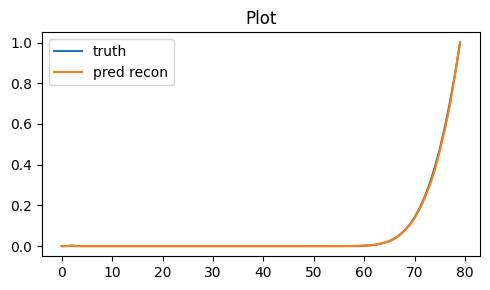

In [25]:
plot(14)

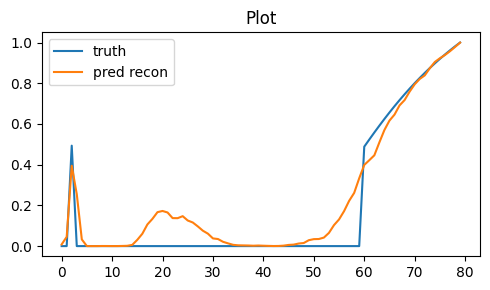

In [26]:
plot(19)

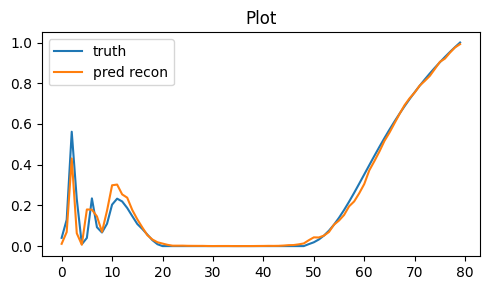

In [27]:
plot(789)

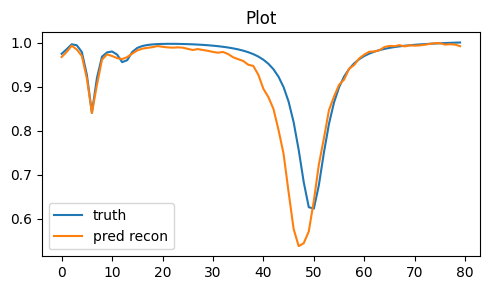

In [23]:
plot(7897)

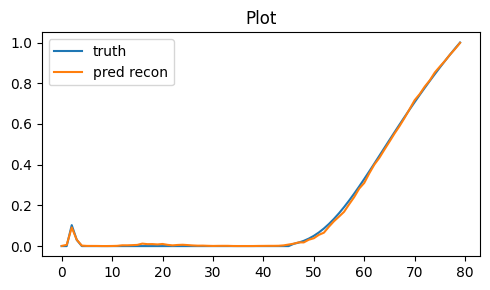

In [15]:
plot(4981)